<a href="https://colab.research.google.com/github/drew-walkerr/Diss_Detecting_Provider_Bias/blob/main/scare_quote_rf_svm_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/
# This is the general format I'm going to use for the BOW classifier for the detecting bias project.
import pandas as pd
import numpy
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn import feature_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import MultinomialNB
# Import modules for evaluation purposes
# Import libraries for predcton
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
import nltk

nltk.download('punkt')
nltk.download('stopwords')


from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score




import torch
torch.cuda.empty_cache()
import seaborn as sns
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import logging
logging.basicConfig(level=logging.ERROR)
from google.colab import output
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

#GPU usage setup
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
import random
random.seed(1)
np.random.seed(1)
torch.cuda.manual_seed(1)
torch.manual_seed(1)




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# mount drive to access data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:

%cd /content/drive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/Scare Quotes/3_Classification

%ls

/content/drive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/Scare Quotes/3_Classification
annotation_Drew_sample_scare_quotes.csv  predictions.csv
drew_gold_standard_scare_quote_500.csv   scare_quote_classification.ipynb
gold_standard_scare_quotes_100.csv       scare_quote_rf_svm_classifiers.ipynb
gold_standard_scare_quotes_500.csv       scare_quotes_accuracy.gsheet


In [4]:
# Read the Annie Sample csv file
df1 = pd.read_csv("gold_standard_scare_quotes_500.csv") #Annie Sample

# Read the Drew Sample csv file
df2 = pd.read_csv("drew_gold_standard_scare_quote_500.csv") #Drew Sample
# Bind the rows of the two dataframes
df = pd.concat([df1, df2], ignore_index=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sentence_id  1003 non-null   int64  
 1   sentence     995 non-null    object 
 2   quoted_text  994 non-null    object 
 3   scare_label  995 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 31.5+ KB


In [5]:
df['label'] = df['scare_label']
df.drop(['sentence_id','scare_label'], axis=1)
del df['sentence_id'], df['scare_label']
# Drop rows with any NaN values
df.dropna(inplace=True)
df.head(3)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 994 entries, 0 to 1002
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sentence     994 non-null    object 
 1   quoted_text  994 non-null    object 
 2   label        994 non-null    float64
dtypes: float64(1), object(2)
memory usage: 31.1+ KB


In [6]:
cols = ['sentence', 'quoted_text']
df['text'] = df[cols].apply(lambda row: '</s>'.join(row.values.astype(str)), axis=1)
df.head(3)

,sentence,quoted_text,label,text
0,"Pt stated year as ""[**2159**]"" and when asked ...",[**2159**],0.0,"Pt stated year as ""[**2159**]"" and when asked ..."
1,Speech evaluation recommended behavioral modif...,break,0.0,Speech evaluation recommended behavioral modif...
2,"psychosocial: pt tearful several times, mouthi...",go home,0.0,"psychosocial: pt tearful several times, mouthi..."


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from datetime import datetime
import time

skf = StratifiedKFold(n_splits=5)
X = df['text'].values
y = df['label'].values

metrics = []

skf = StratifiedKFold(n_splits=5)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    vect = CountVectorizer(ngram_range=(1, 2), max_features=10000, stop_words="english")
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)


# Define the parameter grids for Naive Bayes, Random Forest, and Logistic Regression
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0],  # Different alpha values for MultinomialNB
}

rf_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
}

lr_param_grid = {
    'C': [0.01, 0.1, 1.0],  # Regularization parameter for Logistic Regression
}

# Create a list to store the results
results = []

# Define a custom scoring function to prioritize precision for the positive class
positive_precision_scorer = make_scorer(precision_score, labels=[1], average='binary')
positive_recall_scorer = make_scorer(recall_score, labels=[1], average='binary')
positive_f1_scorer = make_scorer(f1_score, labels=[1], average='binary')

# Define custom scoring functions for negative class
negative_precision_scorer = make_scorer(precision_score, labels=[0], average='binary')
negative_recall_scorer = make_scorer(recall_score, labels=[0], average='binary')
negative_f1_scorer = make_scorer(f1_score, labels=[0], average='binary')

# Perform grid search for Naive Bayes
nb_grid_search = GridSearchCV(MultinomialNB(), nb_param_grid, cv=5, scoring='accuracy', verbose=1)
start_time = time.time()
nb_grid_search.fit(X_train_dtm, y_train)
end_time = time.time()
duration = end_time - start_time

# Get the best hyperparameters and the corresponding model
best_nb_model = nb_grid_search.best_estimator_
best_nb_params = nb_grid_search.best_params_

# Evaluate the Naive Bayes model on the test set
nb_test_predictions = best_nb_model.predict(X_test_dtm)
nb_accuracy = accuracy_score(y_test, nb_test_predictions)
nb_positive_precision = precision_score(y_test, nb_test_predictions, labels=[1], average='binary')
nb_positive_recall = recall_score(y_test, nb_test_predictions, labels=[1], average='binary')
nb_positive_f1 = f1_score(y_test, nb_test_predictions, labels=[1], average='binary')
nb_negative_precision = precision_score(y_test, nb_test_predictions, labels=[0], average='binary')
nb_negative_recall = recall_score(y_test, nb_test_predictions, labels=[0], average='binary')
nb_negative_f1 = f1_score(y_test, nb_test_predictions, labels=[0], average='binary')
nb_macro_precision = (nb_positive_precision + nb_negative_precision) / 2
nb_macro_recall = (nb_positive_recall + nb_negative_recall) / 2
nb_macro_f1 = (nb_positive_f1 + nb_negative_f1) / 2

# Store the results for Naive Bayes
results.append({
    'Model': 'Multinomial Naive Bayes',
    'Hyperparameters': best_nb_params,
    'Accuracy': nb_accuracy,
    'Positive Precision': nb_positive_precision,
    'Positive Recall': nb_positive_recall,
    'Positive F1': nb_positive_f1,
    'Negative Precision': nb_negative_precision,
    'Negative Recall': nb_negative_recall,
    'Negative F1': nb_negative_f1,
    'Macro Precision': nb_macro_precision,
    'Macro Recall': nb_macro_recall,
    'Macro F1': nb_macro_f1,
    'Timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Duration (s)': duration
})

# Perform grid search for Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=1), rf_param_grid, cv=5, scoring='accuracy', verbose=1)
start_time = time.time()
rf_grid_search.fit(X_train_dtm, y_train)
end_time = time.time()
duration = end_time - start_time

# Get the best hyperparameters and the corresponding model
best_rf_model = rf_grid_search.best_estimator_
best_rf_params = rf_grid_search.best_params_

# Evaluate the Random Forest model on the test set
rf_test_predictions = best_rf_model.predict(X_test_dtm)
rf_accuracy = accuracy_score(y_test, rf_test_predictions)
rf_positive_precision = precision_score(y_test, rf_test_predictions, labels=[1], average='binary')
rf_positive_recall = recall_score(y_test, rf_test_predictions, labels=[1], average='binary')
rf_positive_f1 = f1_score(y_test, rf_test_predictions, labels=[1], average='binary')
rf_negative_precision = precision_score(y_test, rf_test_predictions, labels=[0], average='binary')
rf_negative_recall = recall_score(y_test, rf_test_predictions, labels=[0], average='binary')
rf_negative_f1 = f1_score(y_test, rf_test_predictions, labels=[0], average='binary')
rf_macro_precision = (rf_positive_precision + rf_negative_precision) / 2
rf_macro_recall = (rf_positive_recall + rf_negative_recall) / 2
rf_macro_f1 = (rf_positive_f1 + rf_negative_f1) / 2

# Store the results for Random Forest
results.append({
    'Model': 'Random Forest',
    'Hyperparameters': best_rf_params,
    'Accuracy': rf_accuracy,
    'Positive Precision': rf_positive_precision,
    'Positive Recall': rf_positive_recall,
    'Positive F1': rf_positive_f1,
    'Negative Precision': rf_negative_precision,
    'Negative Recall': rf_negative_recall,
    'Negative F1': rf_negative_f1,
    'Macro Precision': rf_macro_precision,
    'Macro Recall': rf_macro_recall,
    'Macro F1': rf_macro_f1,
    'Timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Duration (s)': duration
})

# Perform grid search for Logistic Regression
lr_grid_search = GridSearchCV(LogisticRegression(max_iter=1000), lr_param_grid, cv=5, scoring='accuracy', verbose=1)
start_time = time.time()
lr_grid_search.fit(X_train_dtm, y_train)
end_time = time.time()
duration = end_time - start_time

# Get the best hyperparameters and the corresponding model
best_lr_model = lr_grid_search.best_estimator_
best_lr_params = lr_grid_search.best_params_

# Evaluate the Logistic Regression model on the test set
lr_test_predictions = best_lr_model.predict(X_test_dtm)
lr_accuracy = accuracy_score(y_test, lr_test_predictions)
lr_positive_precision = precision_score(y_test, lr_test_predictions, labels=[1], average='binary')
lr_positive_recall = recall_score(y_test, lr_test_predictions, labels=[1], average='binary')
lr_positive_f1 = f1_score(y_test, lr_test_predictions, labels=[1], average='binary')
lr_negative_precision = precision_score(y_test, lr_test_predictions, labels=[0], average='binary')
lr_negative_recall = recall_score(y_test, lr_test_predictions, labels=[0], average='binary')
lr_negative_f1 = f1_score(y_test, lr_test_predictions, labels=[0], average='binary')
lr_macro_precision = (lr_positive_precision + lr_negative_precision) / 2
lr_macro_recall = (lr_positive_recall + lr_negative_recall) / 2
lr_macro_f1 = (lr_positive_f1 + lr_negative_f1) / 2

# Store the results for Logistic Regression
results.append({
    'Model': 'Logistic Regression',
    'Hyperparameters': best_lr_params,
    'Accuracy': lr_accuracy,
    'Positive Precision': lr_positive_precision,
    'Positive Recall': lr_positive_recall,
    'Positive F1': lr_positive_f1,
    'Negative Precision': lr_negative_precision,
    'Negative Recall': lr_negative_recall,
    'Negative F1': lr_negative_f1,
    'Macro Precision': lr_macro_precision,
    'Macro Recall': lr_macro_recall,
    'Macro F1': lr_macro_f1,
    'Timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Duration (s)': duration
})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Save the results to a CSV file
results_df.to_csv('scare_quotes_model_results.csv', index=False)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 3 candidates, totalling 15 fits
                     Model                                    Hyperparameters  \
0  Multinomial Naive Bayes                                     {'alpha': 1.0}   
1            Random Forest  {'max_depth': None, 'min_samples_split': 5, 'n...   
2      Logistic Regression                                        {'C': 0.01}   

   Accuracy  Positive Precision  Positive Recall  Positive F1  \
0  0.777778            0.434783         0.243902       0.3125   
1  0.792929            0.000000         0.000000       0.0000   
2  0.787879            0.000000         0.000000       0.0000   

   Negative Precision  Negative Recall  Negative F1  Macro Precision  \
0            0.434783         0.243902       0.3125         0.434783   
1            0.000000         0.000000       0.0000         0.000000   
2            0.000000         0.000000       0.0000         0.000000   

   Macro Recall  Macro F1            Timestamp  Duration (s)  
0 

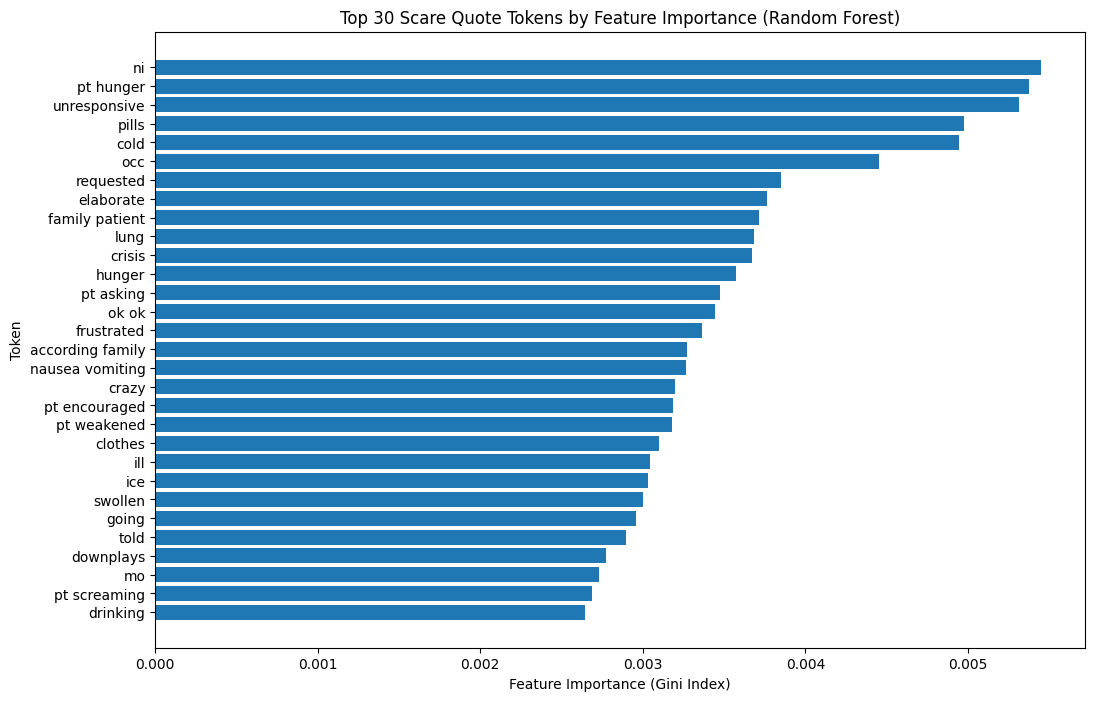

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the best Random Forest model
feature_importances = best_rf_model.feature_importances_

# Get the names of the features (tokens)
feature_names = np.array(vect.get_feature_names_out())

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Get the top 35 tokens and their importances
top_tokens = feature_names[sorted_indices][:30]
top_importances = feature_importances[sorted_indices][:30]

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_tokens)), top_importances, align='center')
plt.yticks(range(len(top_tokens)), top_tokens)
plt.xlabel('Feature Importance (Gini Index)')
plt.ylabel('Token')
plt.title('Top 30 Scare Quote Tokens by Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important tokens at the top
plt.savefig("scare_quote_feature_importance_plot.png", bbox_inches='tight')  # Save the figure before showing it
plt.show()



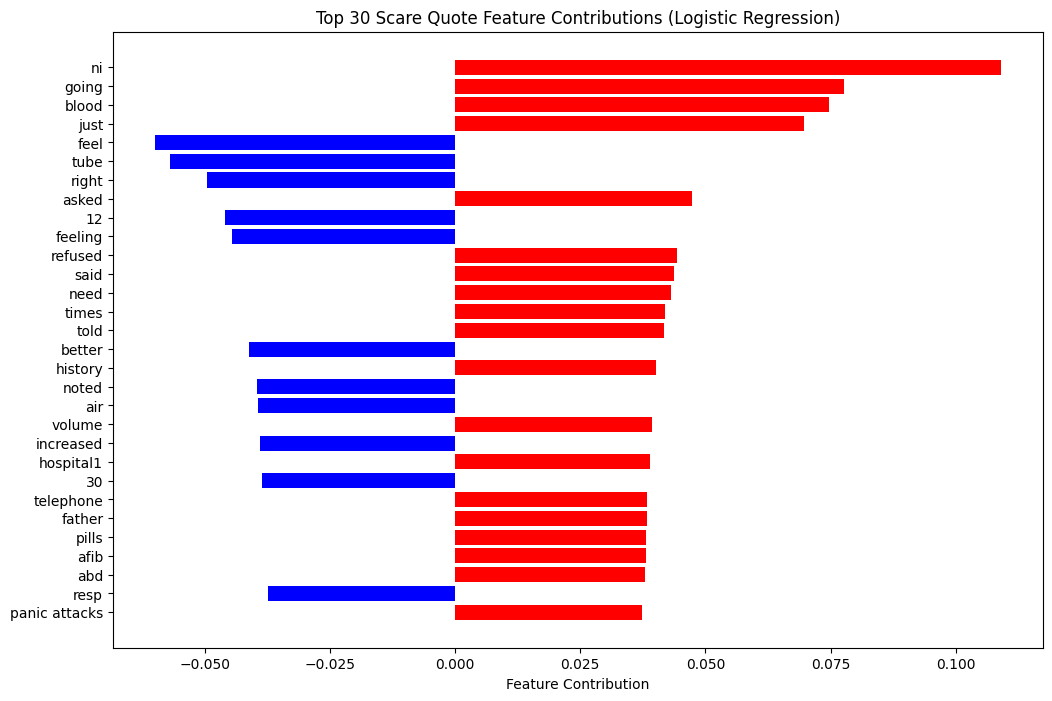

In [9]:
# Calculate feature contributions
coefs = best_lr_model.coef_  # Coefficients for each feature
feature_names = vect.get_feature_names_out()

# Create a DataFrame to store feature contributions
contributions_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs[0]})

# Sort the DataFrame by the absolute value of coefficients to identify significant features
contributions_df['Absolute_Coefficient'] = np.abs(contributions_df['Coefficient'])
contributions_df = contributions_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Select the top N significant features for the plot
top_features = contributions_df.head(30)

# Determine the color for each bar based on the coefficient value
colors = ['red' if coef > 0 else 'blue' for coef in top_features['Coefficient']]

# Plot the feature contributions
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'], align='center', color=colors)
plt.xlabel('Feature Contribution')
plt.title('Top 30 Scare Quote Feature Contributions (Logistic Regression)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most significant features at the top
plt.savefig("scare_quote_feature_contributions_plot.png", bbox_inches='tight')  # Save the figure before showing it
plt.show()
